In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow
import optuna
import xgboost as xgb
from mlflow_helper import get_or_create_experiment
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from syntetic_data_helper import generate_apple_sales_data_with_promo_adjustment, plot_correlation_with_demand, plot_feature_importance, plot_residuals
optuna.logging.set_verbosity(optuna.logging.ERROR)


c:\Users\jorge\anaconda3\envs\optuna\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df

c:\Users\jorge\Repo\ML\hyperparam-search\syntetic_data_helper.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
c:\Users\jorge\Repo\ML\hyperparam-search\syntetic_data_helper.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
c:\Users\jorge\Repo\ML\hyperparam-search\

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2011-02-23 19:15:35.743952,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677
1,2011-02-24 19:15:35.743952,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318
2,2011-02-25 19:15:35.743952,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485
3,2011-02-26 19:15:35.743952,23.648154,12.030937,1,0,1.839225,0,1099.833810,857.895424,0.761740,0.872803
4,2011-02-27 19:15:35.743952,13.861391,4.303812,1,0,1.531772,0,1283.949061,1148.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-10-27 19:15:35.736051,21.643051,3.821656,1,0,2.391010,1,1835.210762,1841.064082,1.504432,0.756489
4996,2024-10-28 19:15:35.736051,13.808813,1.080603,0,1,0.898693,1,1563.149505,1884.454273,1.343586,0.742145
4997,2024-10-29 19:15:35.736051,11.698227,1.911000,0,0,2.839860,1,1243.171368,1562.407359,2.771896,0.742145
4998,2024-10-30 19:15:35.736051,18.052081,1.000521,0,0,1.188440,1,1646.369501,1292.429223,2.564075,0.742145


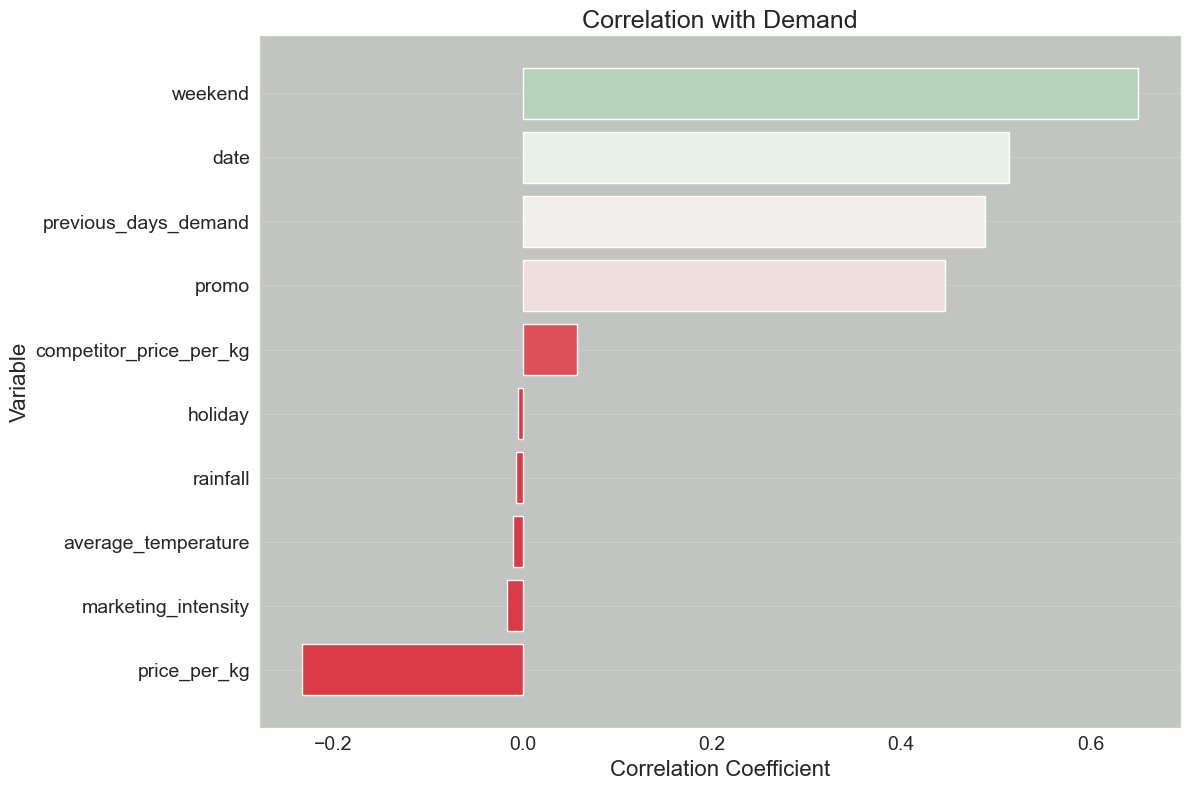

In [4]:
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")
correlation_plot

In [5]:
experiment_id = get_or_create_experiment("Apples Demand")
run_name = "first_attempt"

In [6]:
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

In [7]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [8]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error


In [9]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


Initial trial 0 achieved value: 62605.392777925685
Trial 1 achieved value: 19189.76368631614 with  226.2437% improvement
Trial 10 achieved value: 19004.91059311472 with  0.9727% improvement
Trial 11 achieved value: 18929.667334133752 with  0.3975% improvement
Trial 16 achieved value: 18889.461598076632 with  0.2128% improvement
Trial 29 achieved value: 16563.3313918846 with  14.0439% improvement
Trial 30 achieved value: 14684.977793261614 with  12.7910% improvement
Trial 41 achieved value: 14641.33003900924 with  0.2981% improvement
Trial 54 achieved value: 14527.901943722945 with  0.7808% improvement
Trial 56 achieved value: 14337.099557242998 with  1.3308% improvement
Trial 85 achieved value: 14327.967592510466 with  0.0637% improvement
Trial 159 achieved value: 14284.527656980741 with  0.3041% improvement
Trial 186 achieved value: 14278.771983636418 with  0.0403% improvement
Trial 278 achieved value: 14166.688301827531 with  0.7912% improvement


c:\Users\jorge\anaconda3\envs\optuna\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
